In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, make_scorer
import pandas as pd
from tqdm import tqdm 
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
# Read in data 
df = pd.read_csv('data.csv', na_values=['NS'])
df = df.fillna(0)

data = df.drop(columns =  ['CRF', 'Begin', ' End', 
                           ' Recombinant Sequence(s)',
                           ' Minor Parental Sequence(s)', 
                           ' Major Parental Sequence(s)',
                           'Undetermined Position'])

# Split data into training and testing sets 
X = data.drop(columns=['Label'])
y = data.Label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [3]:
"""
Bagged decision tree 
"""
# Fit a bagged decision tree to the data 
bag_model = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, n_jobs=-1, random_state=1)
bag_model.fit(X_train, y_train)

# Make predictions with bagged decision tree model 
bag_y_pred = bag_model.predict(X_test)


In [4]:
kf = KFold(n_splits=5, shuffle=False)

# Define the scorer 
sc = make_scorer(accuracy_score)

# Validate the model 
cross_validation_scores = cross_val_score(bag_model, X_train, y_train, cv=kf, scoring=sc)
print("Cross validation accuracy: {}".format(cross_validation_scores.mean()))



# Calculate the accuracy for the bagged decision tree 
bag_accuracy = accuracy_score(y_test, bag_y_pred)

print(bag_accuracy)

Cross validation accuracy: 0.6278409090909091
0.5365853658536586


In [5]:
"""
Random forest tree with max_features = 1 
"""

# Fit a random forest model with max_features = 1 to the data 
rf_mf1_model = RandomForestClassifier(n_estimators=1000,              # Number of trees to train
                                      criterion="entropy", 
                                      min_samples_leaf=0.001,        # Minimum samples in a leaf
                                      max_features="auto",             # Maximum number of features per split 
                                      min_impurity_decrease=0.001,  # Minimum impurity decrease. 
                                      oob_score=True,                # If report accuracy with non-selected cases. 
                                      n_jobs=-1,                     # Parallel processing
                                      verbose=1,                     
                                      class_weight="balanced",
                                      random_state=1)           
rf_mf1_model.fit(X_train, y_train)

# Make predictions with random forest model with max_features = 1 
rf_mf1_y_pred = rf_mf1_model.predict(X_test)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [6]:
kf = KFold(n_splits=5, shuffle=False)

# Define the scorer 
sc = make_scorer(accuracy_score)

# Validate the model 
cross_validation_scores = cross_val_score(rf_mf1_model, X_train, y_train, cv=kf, scoring=sc)
print("Cross validation Accuracy: {}".format(cross_validation_scores.mean()))


# Calculate the accuracy for the random forest model
rf_mf1_accuracy = accuracy_score(y_test, rf_mf1_y_pred)
print("Testing Accuracy: {}".format(rf_mf1_accuracy))

# Training loss 
rf_mf1_y_pred = rf_mf1_model.predict(X_train)
rf_mf1_accuracy = accuracy_score(y_train, rf_mf1_y_pred)
print("Training Accuracy: {}".format(rf_mf1_accuracy))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1

Cross validation Accuracy: 0.6465909090909091
Testing Accuracy: 0.5609756097560976
Training Accuracy: 0.9751552795031055


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [7]:
"""
XGboost model 
"""
# Fit an XGboost model to the data 
XGB_model = XGBClassifier(max_depth=5,                 
                          learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                          n_estimators=500,            # Number of trees to use
                          objective='binary:logistic',  # Type of target variable.
                          booster='gbtree',             # Boosting trees 
                          n_jobs=-1,                    # Parallelization 
                          gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree.
                          reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                          reg_lambda=0,                 # Regularizer for first fit.
                          random_state=1
                         )

XGB_model.fit(X_train, y_train)

# Make predictions with the XGB model  
XGB_model_y_pred = XGB_model.predict(X_test)
    

In [8]:
kf = KFold(n_splits=5, shuffle=False)

# Define the scorer 
sc = make_scorer(accuracy_score)

# Validate the model 
cross_validation_scores = cross_val_score(XGB_model, X_train, y_train, cv=kf, scoring=sc)
print("Cross validation accuracy: {}".format(cross_validation_scores.mean()))

# Calculate the accuracy for the XGB model 
XGB_accuracy = accuracy_score(y_test, XGB_model_y_pred)
print(XGB_accuracy)


XGB_model_y_pred = XGB_model.predict(X_train)
XGB_accuracy = accuracy_score(y_train, XGB_model_y_pred)
print(XGB_accuracy)


Cross validation accuracy: 0.6153409090909091
0.5365853658536586
0.9875776397515528


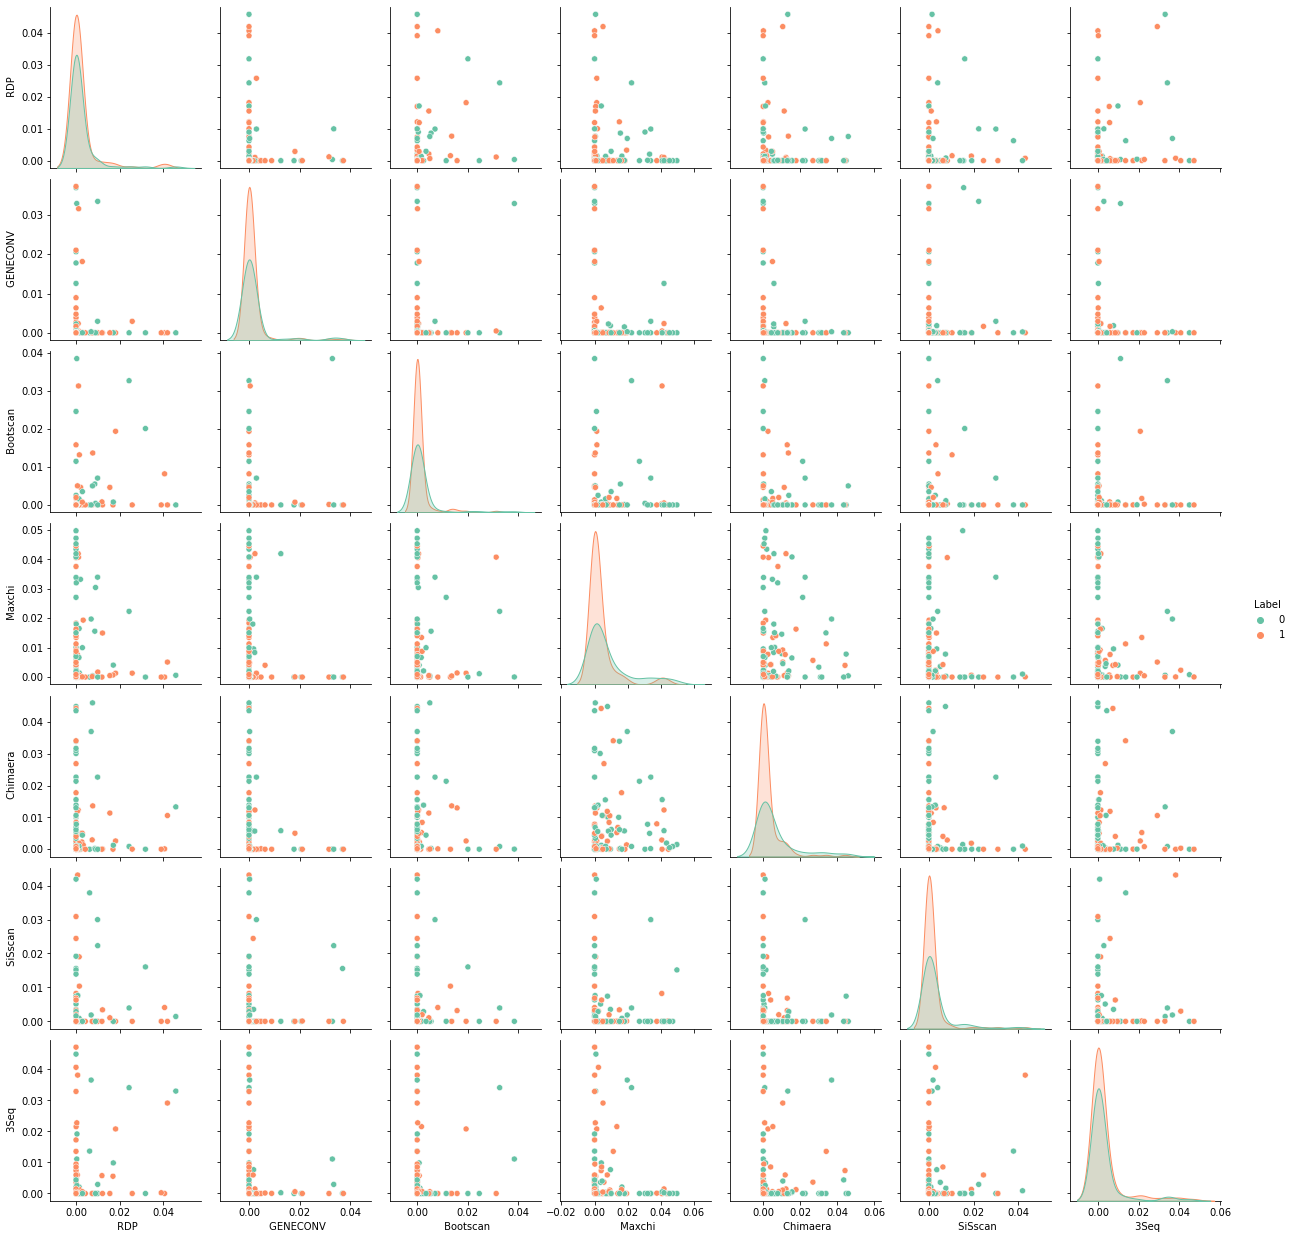

In [9]:
# Visualizing class separation 
g = sns.pairplot(data, hue="Label", palette="Set2", diag_kind="kde")